In [1]:
# pip install directly into notebook
%pip install sklearn
%pip install pandas
%pip install imbalanced-learn

You should consider upgrading via the '/home/robert/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/robert/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/robert/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sklearn as sk
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold, cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neural_network import MLPRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import time


In [3]:
# disable warning for chained assignment (not necessary but cleans up the project)
pd.options.mode.chained_assignment = None

# taken from kaggle example
class ReplaceZeroTransformer():
    """Eliminates Zero values from tempo columns and replace it 
       with the median or mean of non-zero values as specified.
       defaut is set to 'median'.
    """

    def __init__(self, method='median'):
        self.method = method

    def transform(self, X):
        if self.method == 'median':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
        elif self.method == 'mean':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
        else:
            raise Exception("Method can be 'median' or 'mean' only!")
        return X
    
# Import track data
usecols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode','popularity', 'speechiness', 'tempo', 'valence']
dataset = pd.read_csv("data.csv", header = 0, usecols=usecols)

# Remove rows duplicated by ignoring some columns
dataset = dataset[~dataset.duplicated()==1]

# Normalize columns having values outside [0, 1]
scaler = MinMaxScaler()
# cols_to_normalize = ['duration_ms', 'key', 'loudness', 'popularity', 'tempo']
cols_to_normalize = ['duration_ms', 'loudness', 'tempo']
dataset[cols_to_normalize] = scaler.fit_transform(dataset[cols_to_normalize])

# print(dataset)

# TODO: further preprocessing?

y = dataset.pop('popularity') # popularity is our class to predict
X_headers = list(dataset.columns.values)
X = dataset

# Create the under sampler
undersample = RandomUnderSampler(sampling_strategy='majority')

# apply the transform
X, y = undersample.fit_resample(X, y)

tempo_transformer = ReplaceZeroTransformer()
X = tempo_transformer.transform(X)

# need to scale after to treat the individual categories as their own class for the undersampling
y = y/100

# one hot encode the keys since they are a multiclass
ohe = OneHotEncoder(categories='auto', drop='first')

feature_arr = ohe.fit_transform(X[['key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X['key'].values))[1:]]
features = pd.DataFrame(feature_arr, columns = columns_key, index = X.index)
X = pd.concat([X, features], axis=1).drop(['key'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# multi-layer perception: 
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
regr = MLPRegressor(hidden_layer_sizes=(100, 10, 5, 1), random_state=1, max_iter=500).fit(X_train, y_train)

# hidden_layer_sizes 
# ------ activation: identity, logistic, tanh, relu
# ------ solver: lbfgs, sgd, adam
# alpha (L2 penalty)
# learning_rate_init

print(f"num layers: {regr.n_layers_}")
# print(f"R^2: {regr.score(X_test, y_test)}")
# print(f"rmse: {mean_squared_error(y_test, regr.predict(X_test), squared=False)}")

In [ ]:
# mlp checking enum parameters
activations = ['relu'] 
solver = ['adam']

r = MLPRegressor(random_state=1)
r.fit(X_train, y_train)
print(f"rmse: {mean_squared_error(y_test, r.predict(X_test), squared=False)}")
        
# best performing = relu w/ lbfgs => takes a really long time to train
# focusing on relu/adam; relu performed the best, although lbfgs is better,
#  it takes too many iterations to be valuable, it would take too long to be feasible
# the docs also specify adam is better performing on relatively large datasets compared
#  lbfgs which is said to converge faster and perform better on small datasets

In [ ]:
r = MLPRegressor(random_state=1, activation='relu', solver='lbfgs', max_iter=500)
r.fit(X_train, y_train)
print(f"rmse: {mean_squared_error(y_test, r.predict(X_test), squared=False)}")


In [ ]:
# 4 hidden layers best
# layers = [(50), (50, 50), (50, 50, 50), (50, 50, 50, 50), (50, 50, 50, 50, 50)]
# for l in layers:
#     r = MLPRegressor(random_state=1, hidden_layer_sizes=l)
#     r.fit(X_train, y_train)
#     print(f"l={l}, rmse: {mean_squared_error(y_test, r.predict(X_test), squared=False)}")
    
layer_size = [25, 50, 100, 200]
num_layers = [1, 2, 3, 4, 5]
for i in layer_size:
    l = list()
    for j in num_layers:
        for k in range(j):
            l.append(i)
        t = tuple(l)
        r = MLPRegressor(random_state=1, hidden_layer_sizes=t)
        r.fit(X_train, y_train)
        print(f"layer_size={i}, num_layers={j}, rmse: {mean_squared_error(y_test, r.predict(X_test), squared=False)}")

# 25:  4 = 0.15546668386556156
# 50:  3 = 0.15460937803611588
# 100: 4 = 0.15271251400531363
# 200: 3 = 0.1514766594636612

In [ ]:
# Hyperparameter tuning

# Set the parameters by cross-validation
tuned_parameters = [
    # {
    #     'hidden_layer_sizes': np.arange(5, 15),
    # },
    {
        'alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
        'learning_rate_init': np.append(0, np.linspace(0.000001, 0.0001, 50))
    }
]

# Available regression metrics are given here: https://scikit-learn.org/stable/modules/classes.html#regression-metric
# https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764
# ensure scikit is >0.18


inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
print("Tuning hyper-parameters begin!")
print()

# clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3)
clf = HalvingGridSearchCV(MLPRegressor(random_state=1), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3, random_state=1)
print("Classifiers established, training data")
print()

clf.fit(X, y)
non_nested_scores = clf.best_score_
print("Best parameters found:", clf.best_params_)
print("Score (mean squared):", -clf.best_score_)

print("Running cross validation")
print()
clf.best_params_["random_state"] = 1
# cross_val_raw_data = cross_validate(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3, return_estimator=True, return_train_score=True)
# clf = tree.DecisionTreeRegressor(**clf.best_params_)
clf = MLPRegressor(**clf.best_params_)
cv_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3,  scoring='neg_mean_squared_error')
print("Cross validation score (mean squared):", -cv_score.mean())

clf.fit(X, y)

In [10]:
# current best model
model = MLPRegressor(hidden_layer_sizes=(200, 200, 200))
model.fit(X, y)

MLPRegressor(hidden_layer_sizes=(200, 200, 200))

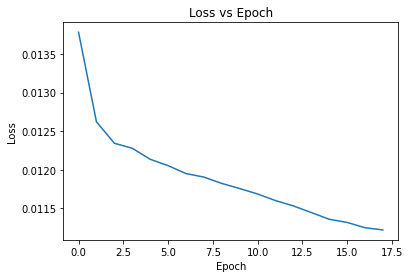

In [12]:
pd.DataFrame(model.loss_curve_).plot(xlabel='Epoch', ylabel='Loss', title='Loss vs Epoch', legend=False)